Script to combine JSON simulation result files into a unified results structure.

Each input file must follow the naming convention:
    `{name}_sim{sim_id}_{timestamp}.json`

and contain a JSON object with keys:
- scenario_name: str
- sim_id: int
- agent_names: list of str
- cum_regrets: list of lists (one per agent)
- time_agents: list of lists (one per agent)

The script aggregates data across multiple files for the same scenario and sim_id,
producing a `results` dict:

```
results[scenario_name] = {
    "scenario_name": scenario_name,
    "sim_id": [list of sim_ids],
    "regrets": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
    "times": {agent_name: np.ndarray of shape (n_simulations, n_draws)},
}
```

## Pre

In [1]:
import os
import glob
import json
import numpy as np

def load_and_combine(json_dir: str = '.'):
    # Temporary storage: scenario -> sim_id -> list of file data dicts
    files_data = {}

    # Collect and parse all JSON files
    for filepath in glob.glob(os.path.join(json_dir, '*.json')):
        with open(filepath, 'r') as f:
            data = json.load(f)
        scenario = data['scenario_name']
        sim_id = data['sim_id']
        # filter out 'Random' agent except for the first time
        rnd_idx = data['agent_names'].index('Random') if 'Random' in data['agent_names'] else None
        if rnd_idx is not None:
            # if this sim_id already has a 'Random' agent, remove it
            for existing_entry in files_data.get(scenario, {}).get(sim_id, []):
                if 'Random' in existing_entry['agent_names']:
                    data['agent_names'].pop(rnd_idx)
                    data['cum_regrets'] = np.delete(data['cum_regrets'], rnd_idx, axis=1).tolist()
                    data['time_agents'] = np.delete(data['time_agents'], rnd_idx, axis=1).tolist()
                    break
        files_data.setdefault(scenario, {}).setdefault(sim_id, []).append({
            'agent_names': data['agent_names'],
            'cum_regrets': data['cum_regrets'],
            'time_agents': data['time_agents'],
        })

    results = {}
    # Combine per scenario
    for scenario_name, sim_dict in files_data.items():
        # Determine all unique agent names
        all_agents = sorted({name for entries in sim_dict.values() for e in entries for name in e['agent_names']})

        # Simulation IDs sorted
        sim_ids = sorted(sim_dict.keys())
        n_simulations = max(sim_ids) + 1
        # Determine number of draws from the first entry
        sample = sim_dict[sim_ids[0]][0]
        n_draws = len(sample['cum_regrets'])

        # Allocate arrays for each agent
        all_regrets = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}
        all_times   = {name: np.zeros((n_simulations, n_draws)) for name in all_agents}

        # Fill arrays with transposed data (draws × agents -> agents × draws)
        for sim_id, entries in sim_dict.items():
            for entry in entries:
                cum_regs = np.array(entry['cum_regrets'])   # shape: (n_draws, n_agents)
                time_ag  = np.array(entry['time_agents'])   # shape: (n_draws, n_agents)
                for i, name in enumerate(entry['agent_names']):
                    all_regrets[name][sim_id, :] = cum_regs[:, i]
                    all_times[name][sim_id, :]   = time_ag[:, i]

        # Build scenario's combined results
        results[scenario_name] = {
            'scenario_name': scenario_name,
            'sim_id': sim_ids,
            'regrets': all_regrets,
            'times': all_times,
        }

    return results

In [2]:
combined = load_and_combine('./results/compare_all')

In [3]:
from compare_agents import *

# print_summary_results(combined)

In [4]:
combined = {k: combined[k] for k in [
    # "Linear",
    # "Friedman",
    # "LinFriedman",
    # "Friedman2",
    # "Friedman3",
    # "Magic",
    # "Shuttle",
    # "Adult",
    # "Mushroom",
    "Iris",
    "Wine",
    "Heart",
    "DrinkLess"
    ] if k in combined}

## Printed Info

In [5]:
print_topn_agents_per_scenario(combined, 15)


Top 15 agents per scenario:
                           Iris                    Wine                   Heart               DrinkLess
Rank 1                     RFTS               XGBoostTS           LogisticBARTm  LogisticBARTo_tree0.5x
Rank 2                XGBoostTS           LogisticBARTo  LogisticBARTm_iter0.5x  LogisticBARTo_iter0.5x
Rank 3   LogisticBARTm_tree0.5x                    RFTS    LogisticBARTm_iter2x           LogisticBARTo
Rank 4   LogisticBARTm_iter0.5x  LogisticBARTo_iter0.5x    LogisticBARTm_tree2x    LogisticBARTo_iter2x
Rank 5     LogisticBARTm_tree2x    LogisticBARTo_iter2x          BARTm_iter0.5x    LogisticBARTm_iter2x
Rank 6            LogisticBARTm  LogisticBARTm_tree0.5x            BARTm_iter2x                    RFTS
Rank 7     LogisticBARTm_iter2x    LogisticBARTm_tree2x          BARTm_tree0.5x           LogisticBARTm
Rank 8   LogisticBARTo_tree0.5x  LogisticBARTm_iter0.5x  LogisticBARTm_tree0.5x    LogisticBARTo_tree2x
Rank 9     LogisticBARTo_tree2x    

In [6]:
print_pairwise_win_tie_lose(combined)

/home/ubuntu/anaconda3/envs/bartpg/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Totals across all scenarios (sorted by win*3+tie):
                        win  tie  lose
RFTS                     31   80     4
LogisticBARTm            22   92     1
LogisticBARTo_tree0.5x   24   86     5
LogisticBARTm_tree2x     22   91     2
LogisticBARTm_iter2x     21   93     1
LogisticBARTm_tree0.5x   19   94     2
LogisticBARTo            17   96     2
LogisticBARTm_iter0.5x   17   94     4
LogisticBARTo_iter2x     17   93     5
XGBoostTS                22   73    20
LogisticBARTo_iter0.5x   11  103     1
BARTm_iter2x             12   98     5
LogisticBARTo_tree2x     13   94     8
BARTo_tree0.5x            9   99     7
BARTm                     8   97    10
BARTm_tree0.5x            7   98    10
BARTm_iter0.5x            6  100     9
BARTo_iter0.5x            6   96    13
BARTo                     7   92    16
BARTo_tree2x              6   94    15
BARTm_tree2x              6   91    18
BARTo_iter2x              6   86    23
LinearTS                  3   65    47
Random      

In [7]:
print_relative_performance(combined)


Agent performance (relative to Random):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
RFTS                         0.489    0.078    0.156
LogisticBARTm_iter2x         0.511    0.053    0.107
LogisticBARTm                0.513    0.056    0.112
LogisticBARTo_tree0.5x       0.515    0.058    0.115
LogisticBARTm_tree0.5x       0.527    0.051    0.102
LogisticBARTm_tree2x         0.535    0.053    0.106
LogisticBARTo                0.536    0.045    0.090
LogisticBARTo_iter0.5x       0.543    0.051    0.102
LogisticBARTm_iter0.5x       0.551    0.068    0.135
LogisticBARTo_iter2x         0.561    0.044    0.088
LogisticBARTo_tree2x         0.562    0.039    0.077
BARTo_tree0.5x               0.585    0.035    0.069
BARTm_iter2x                 0.590    0.041    0.083
BARTm_iter0.5x               0.603    0.051    0.102
BARTm_tree0.5x               0.605    0.045    0.089
BARTo_iter0.5x               0.611    0.030 

In [8]:
print_relative_performance(combined, "times")


Agent performance (relative to Random):
Agent                         Mean       SE Std (stability)
-----------------------------------------------------------
Random                       0.007    0.005    0.010
LinearTS                     0.107    0.078    0.157
BARTo_tree0.5x               2.491    1.574    3.147
BARTo_iter0.5x               2.763    1.644    3.288
BARTm_tree0.5x               2.830    1.839    3.677
BARTm_iter0.5x               3.129    1.913    3.826
BARTo                        4.741    3.028    6.057
BARTm                        5.991    3.819    7.637
LogisticBARTo_tree0.5x       7.396    4.623    9.246
LogisticBARTm_tree0.5x       8.116    5.215   10.430
LogisticBARTo_iter0.5x       8.214    4.825    9.651
BARTo_iter2x                 8.610    5.753   11.506
LogisticBARTm_iter0.5x       9.016    5.446   10.892
BARTo_tree2x                 9.183    5.889   11.777
BARTm_iter2x                 9.860    6.690   13.380
BARTm_tree2x                10.527    6.879 

## Plot & Print

In [9]:
plot_print_total_regret_factors(combined)


Mean relative regret by "Model" category (rows) and scenario (columns):
           Logistic m  Logistic o       m       o
Average         0.096       0.095   0.109   0.102
DrinkLess       5.535       4.328   6.760   5.987
Heart          67.200      84.600  72.400  97.900
Iris           44.675      52.375  62.275  58.000
Wine          880.925     876.625 894.875 888.175

Mean relative regret by "Tree" category (rows) and scenario (columns):
             0.5x      1x      2x
Average     0.100   0.101   0.101
DrinkLess   5.299   5.499   6.325
Heart      77.875  79.750  82.125
Iris       52.219  54.531  55.500
Wine      883.156 884.125 889.438

Mean relative regret by "Iter" category (rows) and scenario (columns):
             0.5x      1x      2x
Average     0.101   0.101   0.100
DrinkLess   5.791   5.499   5.349
Heart      80.875  79.750  82.000
Iris       52.719  54.531  56.688
Wine      884.594 884.125 884.438

Mean relative regret by "MC" category (rows) and scenario (columns):
Empty

## "Beautiful" Plots

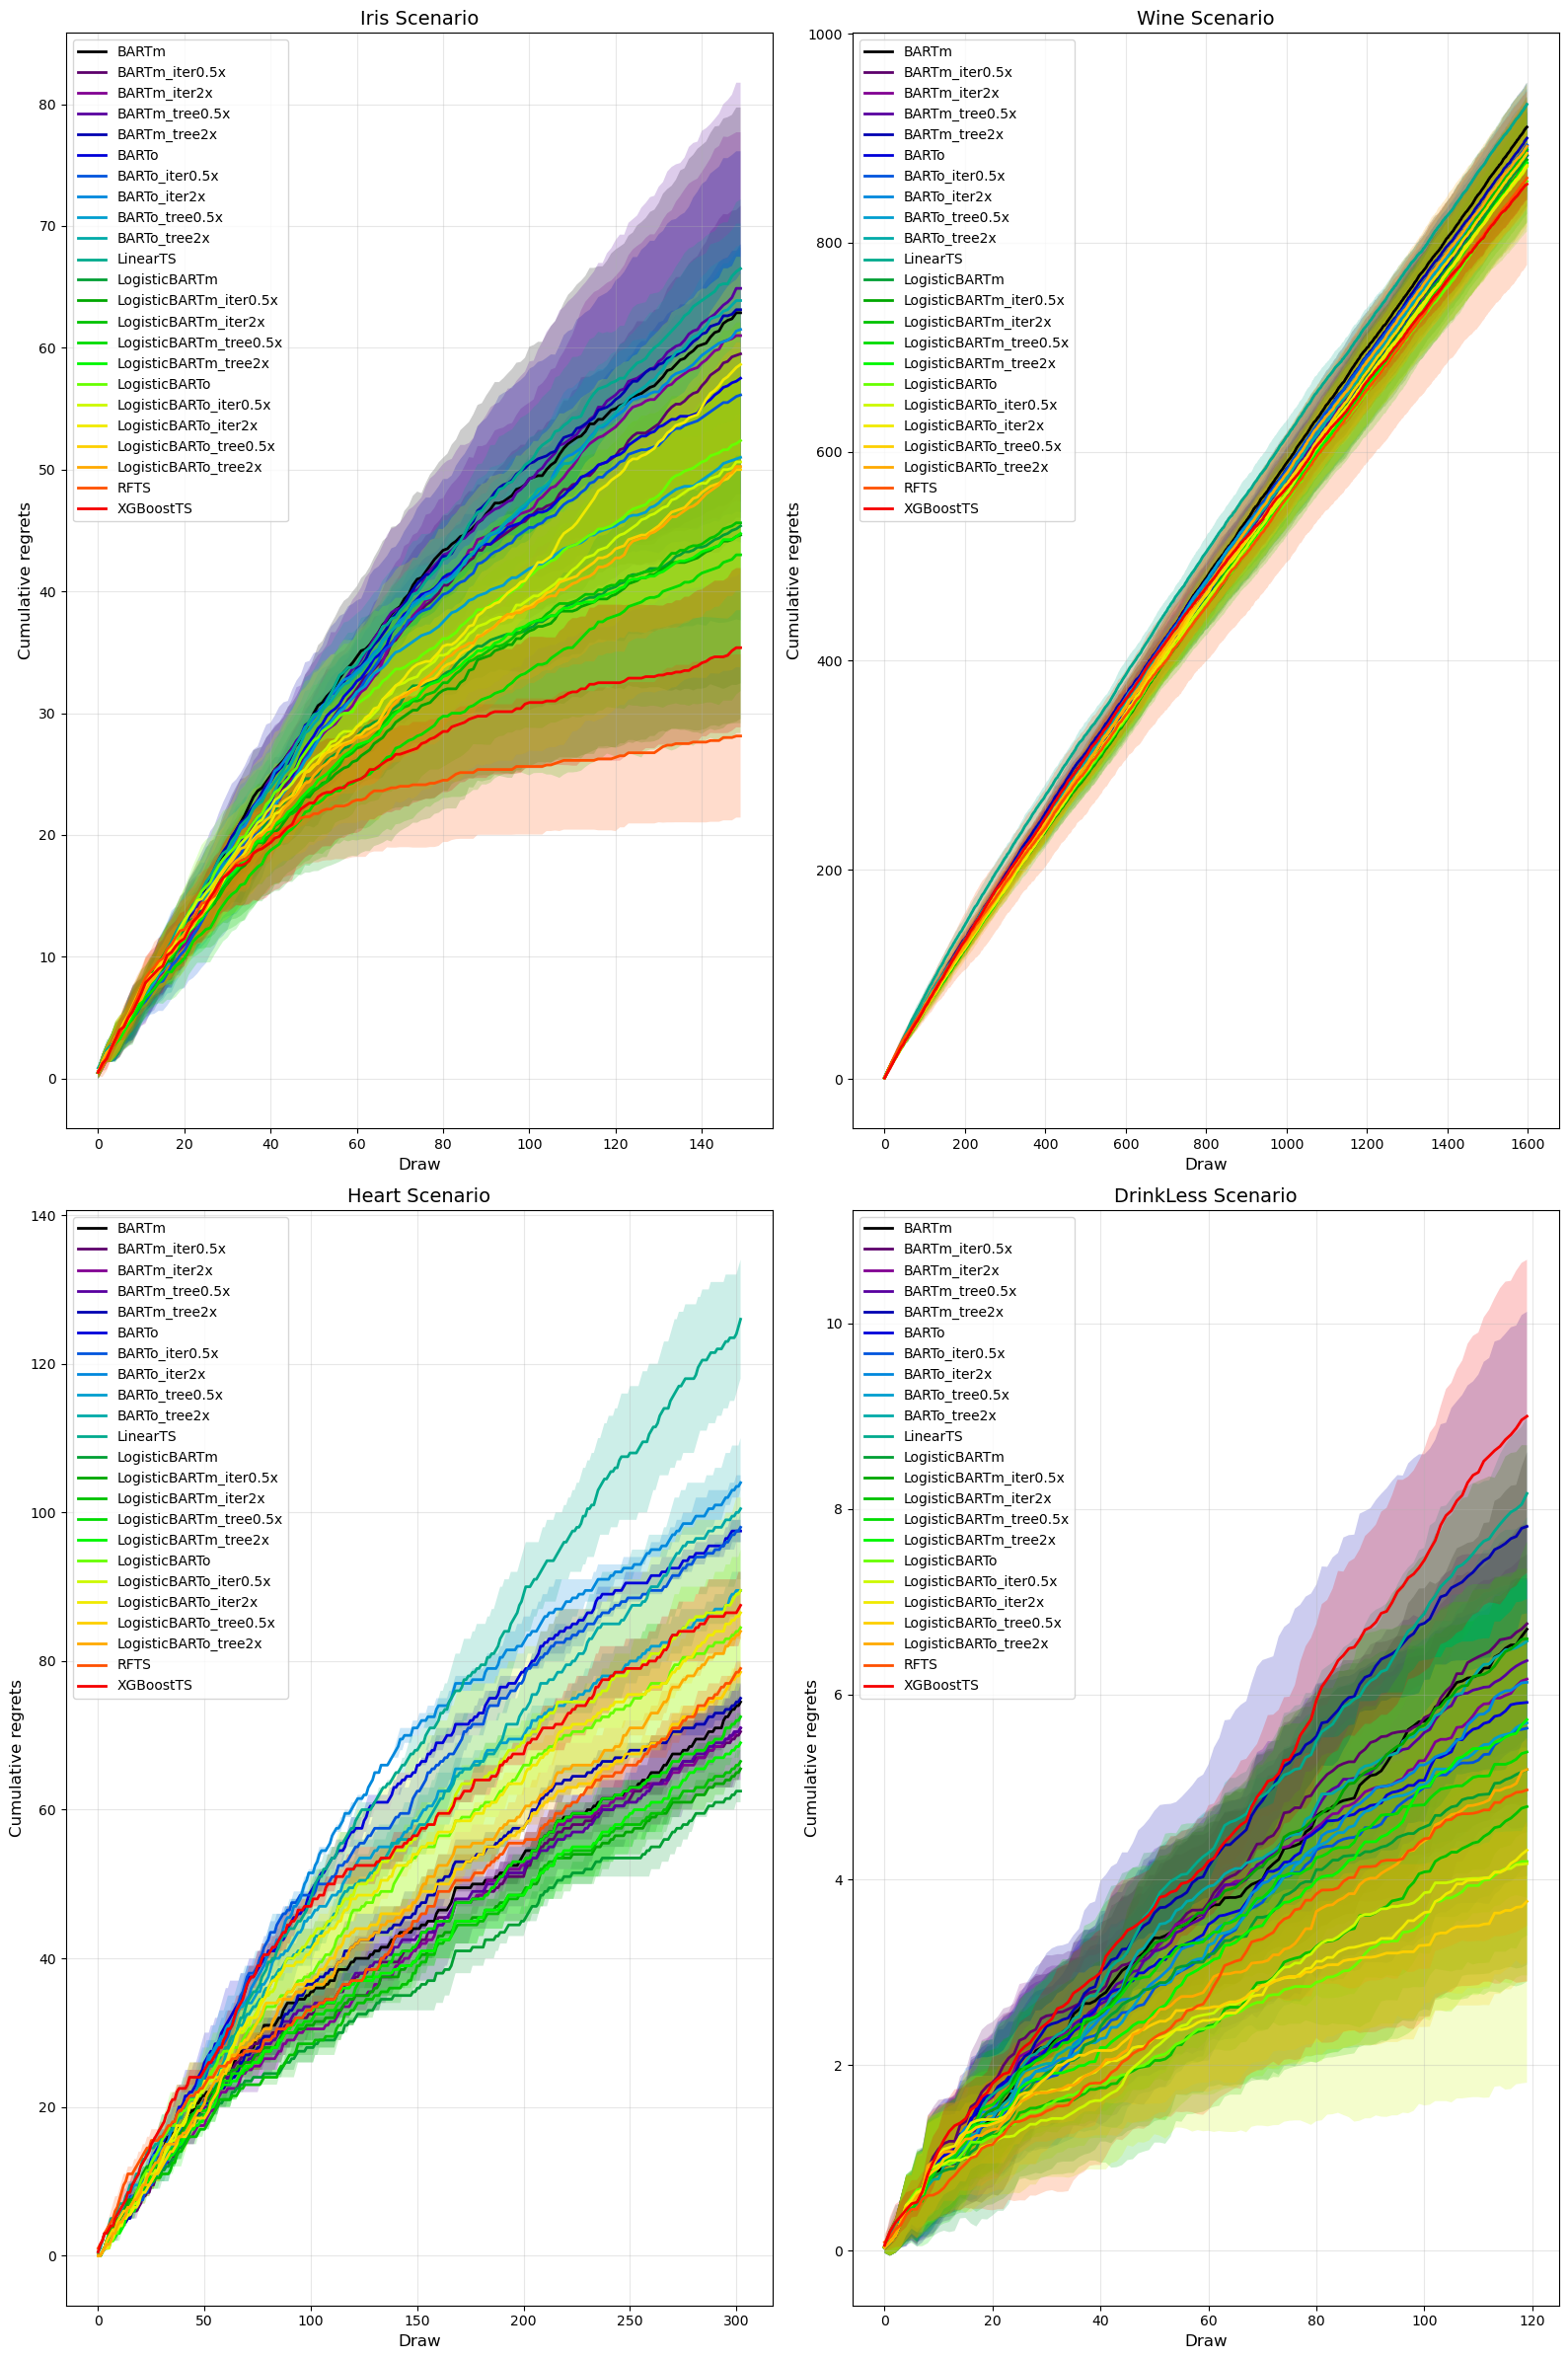

In [10]:
plot_comparison_results(combined, show_random=False)

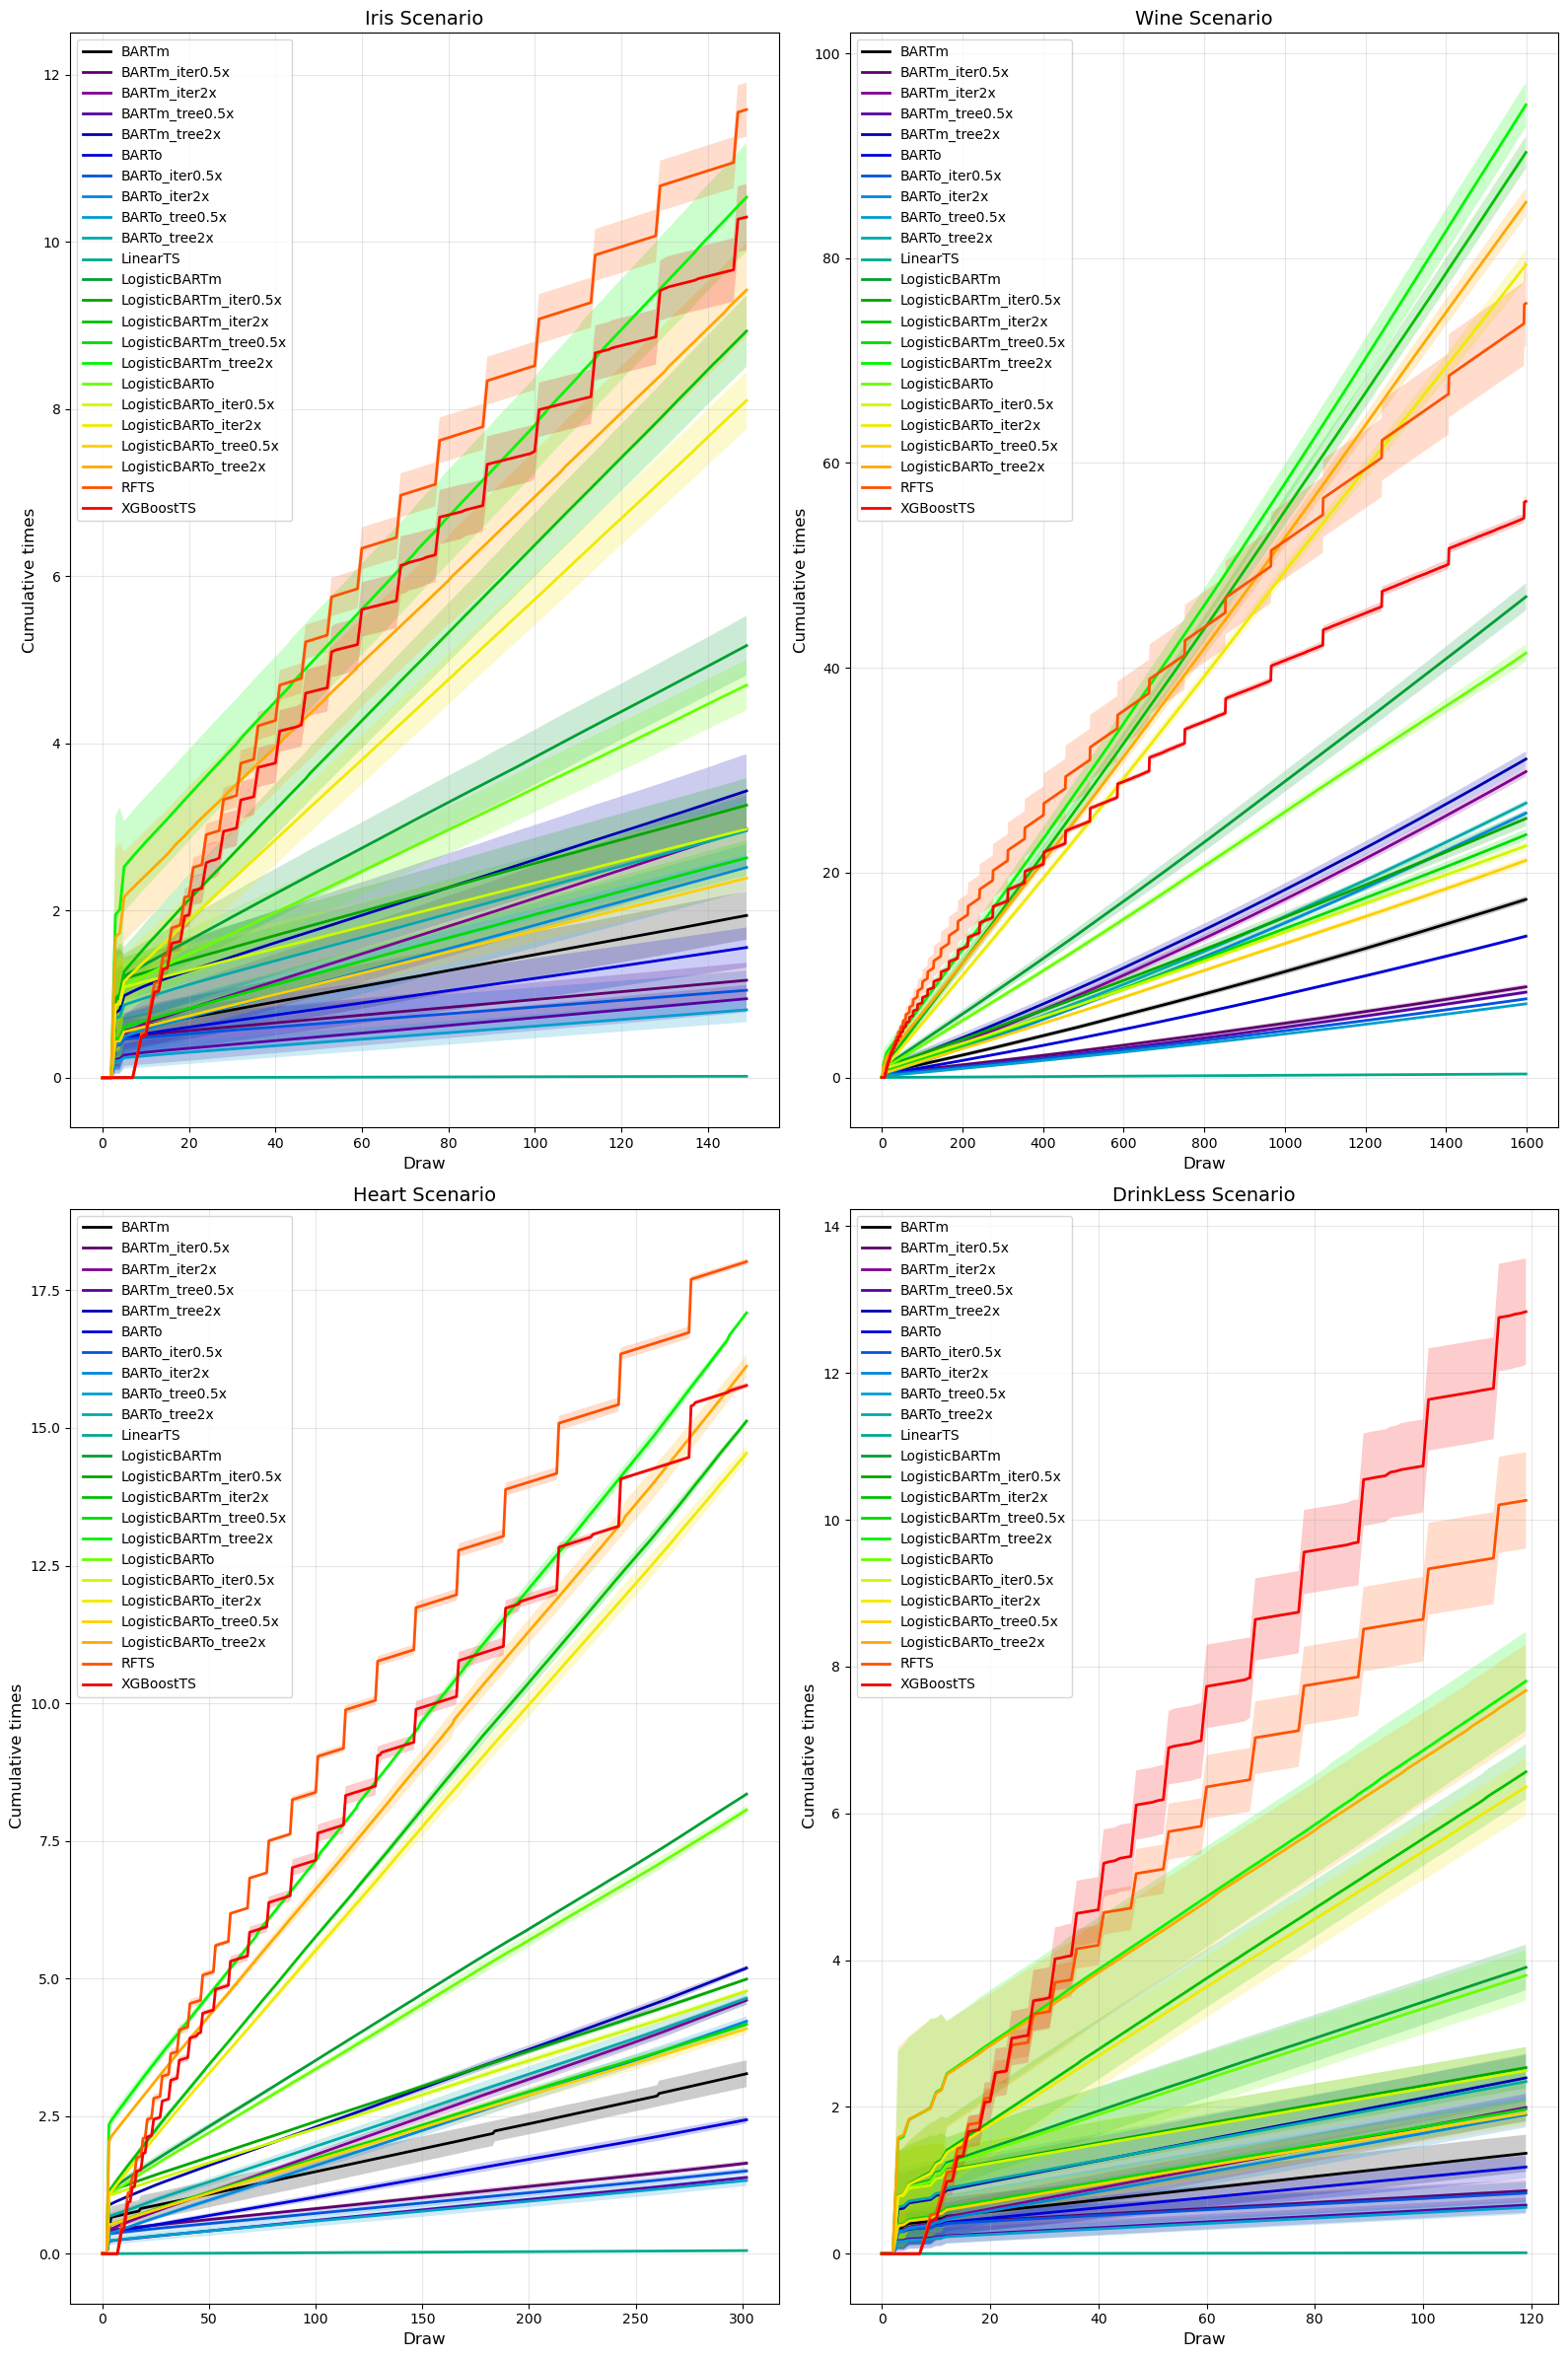

In [11]:
plot_comparison_results(combined, show_random=False, target="times")